In [1]:
from dataclasses import dataclass
from typing import Generator
from typing import List
import shutil
import sys
import os

HOME = os.getcwd()
sys.path.append(f"{HOME}/ByteTrack")

from yolox.tracker.byte_tracker import BYTETracker, STrack
from lavis.models import load_model_and_preprocess

from onemetric.cv.utils.iou import box_iou_batch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from IPython import display
from PIL import Image
import numpy as np
import supervision
import ultralytics
import yolox
import torch
import cv2


display.clear_output()
ultralytics.checks()

print("yolox.__version__:", yolox.__version__)

%matplotlib inline

Ultralytics YOLOv8.0.124 🚀 Python-3.10.6 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090 Ti, 24564MiB)
Setup complete ✅ (16 CPUs, 26.4 GB RAM, 112.0/1006.9 GB disk)


yolox.__version__: 0.1.0


In [2]:
HOME = os.getcwd()
SOURCE_VIDEO_PATH = f"{HOME}/people_car.mp4"
TARGET_VIDEO_PATH = f"{HOME}/labels.mp4"
model = YOLO('yolov8s.pt')
model.fuse()
CLASS_NAMES_DICT = model.model.names
print(CLASS_NAMES_DICT)

YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs


{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [3]:
OUTPUT_PATH = 'output/'
if OUTPUT_PATH is not None:
    if os.path.exists(OUTPUT_PATH):
        shutil.rmtree(OUTPUT_PATH)
    
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH, exist_ok=True)

In [4]:
@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: supervision.Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(detections: supervision.Detections, tracks: List[STrack]) -> supervision.Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

def get_video_frames_generator(source_path: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(source_path)
    if not video.isOpened():
        raise Exception(f"Could not open video at {source_path}")
    success, frame = video.read()
    while success:
        yield Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        success, frame = video.read()
    video.release()
    
def normalize(vec: np.ndarray):
    return vec / np.linalg.norm(vec, axis=1, keepdims=True)

In [5]:
zone_coords = [
    [0, 780],
    [761, 540],
    [1920, 888],
    [1920, 1080]
]

In [6]:
colors = supervision.ColorPalette.default()
video_info = supervision.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

byte_tracker = BYTETracker(BYTETrackerArgs())
generator = supervision.get_video_frames_generator(SOURCE_VIDEO_PATH)

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

### This is the model for captioning
model_blip, vis_processors, txt_processors = load_model_and_preprocess(
    name="blip_caption", model_type="large_coco", is_eval=True, device=device
)
vis_processors.keys()

dict_keys(['train', 'eval'])

In [8]:
colors = supervision.ColorPalette.default()
video_info = supervision.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

byte_tracker = BYTETracker(BYTETrackerArgs())
generator = supervision.get_video_frames_generator(SOURCE_VIDEO_PATH)

polygons = [
    np.array([
        zone_coords[0],
        zone_coords[1],
        zone_coords[2],
        zone_coords[3],
        [0, video_info.resolution_wh[1]]

    ], np.int32)
]

zones = [
    supervision.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=video_info.resolution_wh
    )
    for polygon
    in polygons
]

zone_annotators = [
    supervision.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=4,
        text_scale=2
    )
    for index, zone
    in enumerate(zones)
]

box_annotators = [
    supervision.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=2,
        text_thickness=2,
        text_scale=1
        )
    for index
    in range(len(polygons))
]

with supervision.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    unique_tracks = []
    coords = []
    frame_ids = []
    for frame_id, frame in enumerate(generator):
        try:
            results = model(frame)[0]

            detections = supervision.Detections(
                xyxy=results.boxes.xyxy.cpu().numpy(),
                confidence=results.boxes.conf.cpu().numpy(),
                class_id=results.boxes.cls.cpu().numpy().astype(int)
            )

            detections = detections[(detections.confidence > .7) & ((detections.class_id == 0) | (detections.class_id == 2))]

            tracks = byte_tracker.update(
                output_results=detections2boxes(detections=detections),
                img_info=frame.shape,
                img_size=frame.shape
            )

            tracker_id = match_detections_with_tracks(
                detections=detections, tracks=tracks
            )

            detections.tracker_id = np.array(tracker_id)

            for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
                mask = zone.trigger(detections=detections)
                detections = detections[mask]
    
                labels = [
                    f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
                    for _, _, confidence, class_id, tracker_id in detections
                ]
            
                for x, id in enumerate(detections.tracker_id):
                    if id not in unique_tracks:
                        x1, y1, x2, y2 = detections.xyxy[x].astype(int)
                        
                        frame_ids.append(frame_id)
                        unique_tracks.append(id)
                        coords.append([x1, y1, x2, y2])
                        
                frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
                frame = zone_annotator.annotate(scene=frame)

        except:
            pass
        sink.write_frame(frame)


0: 384x640 8 persons, 1 bicycle, 92.1ms
Speed: 4.5ms preprocess, 92.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 bicycles, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 bicycles, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 bicycles, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 bicycles, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bicycle, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bicycle, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bicycle, 7.8ms
Sp

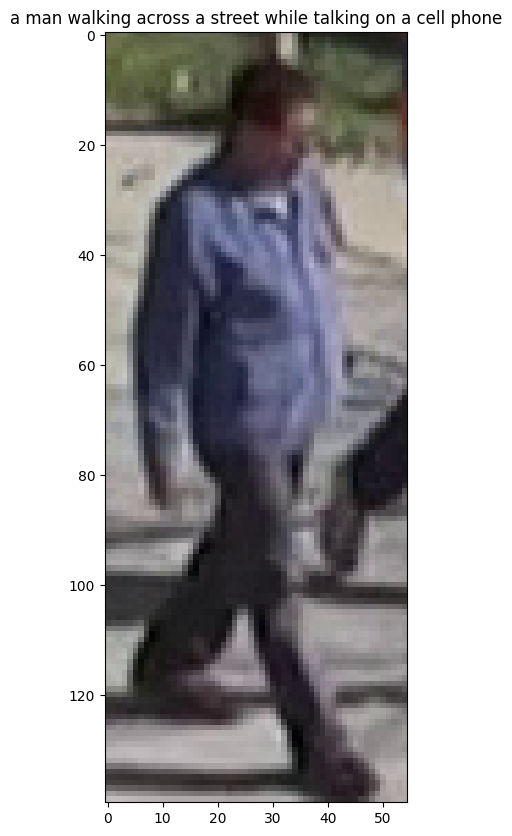

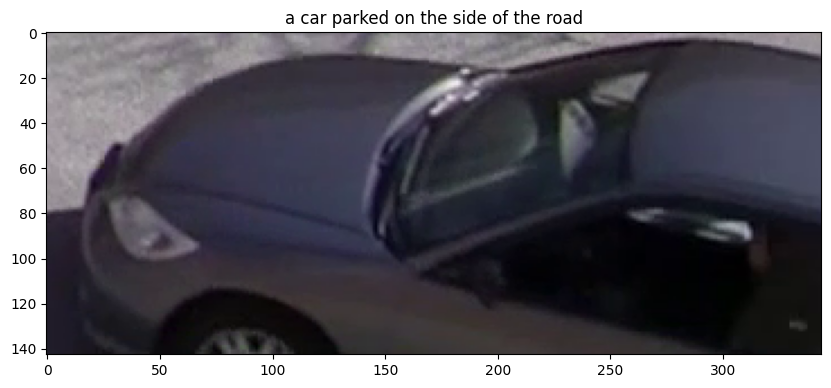

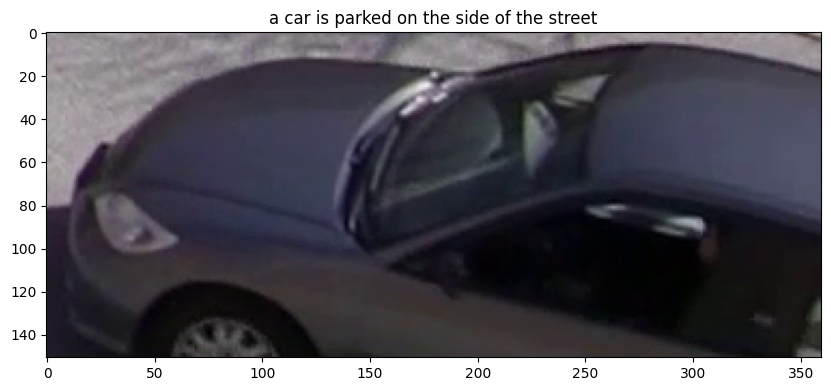

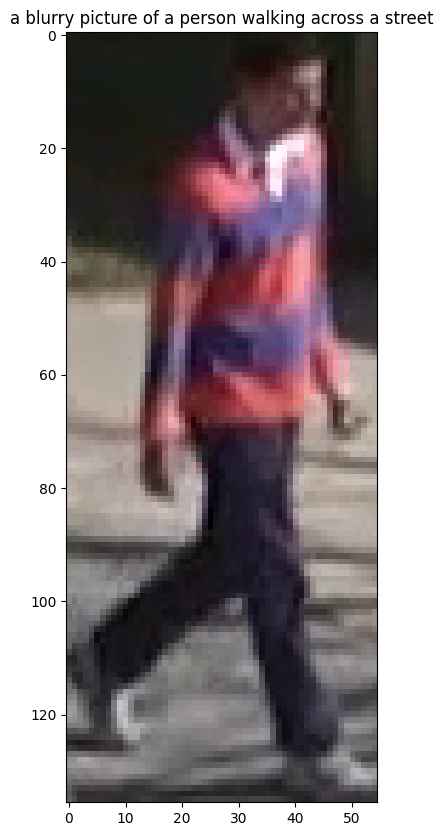

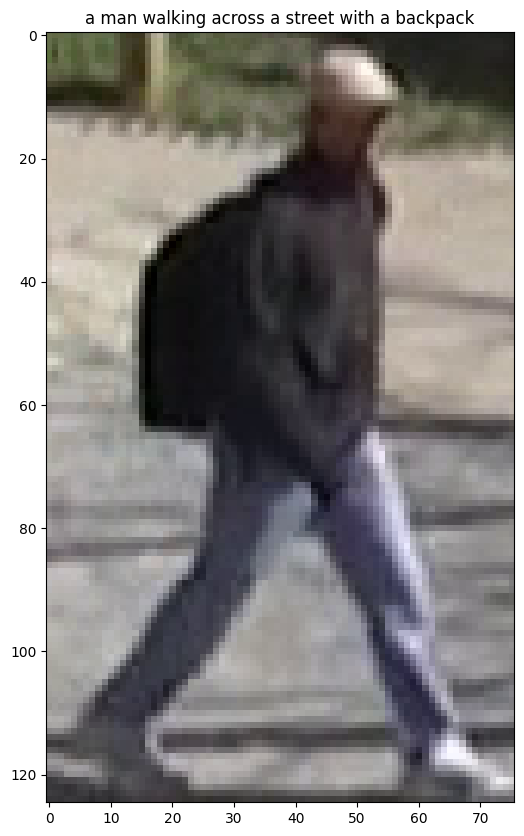

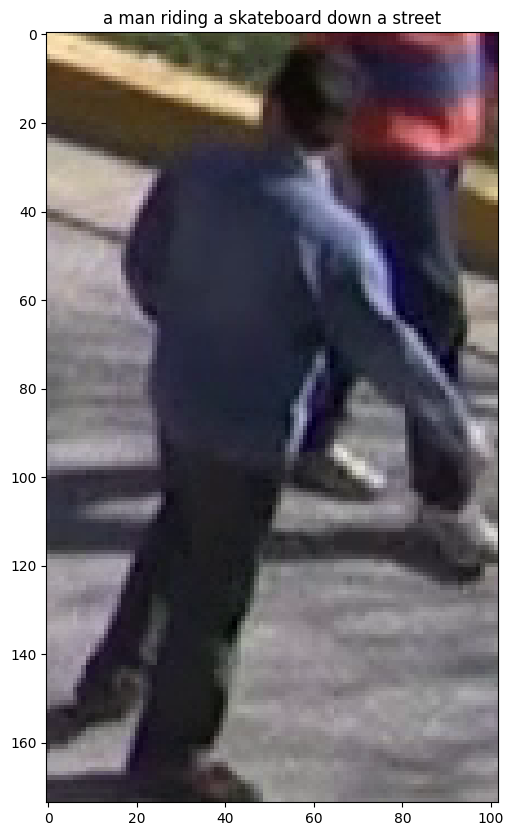

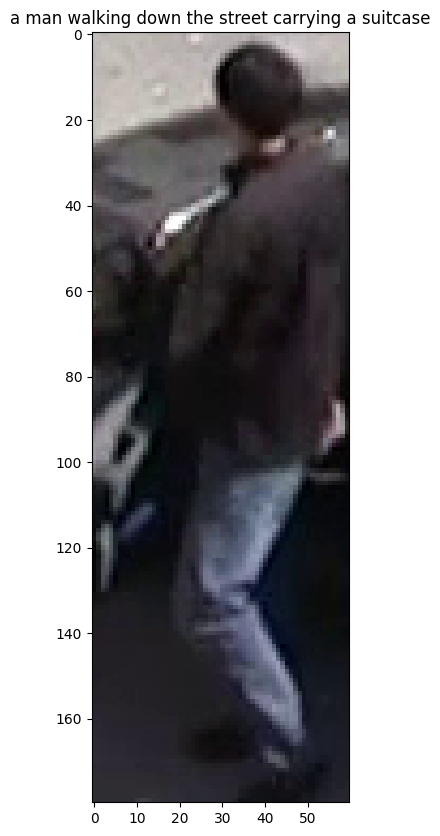

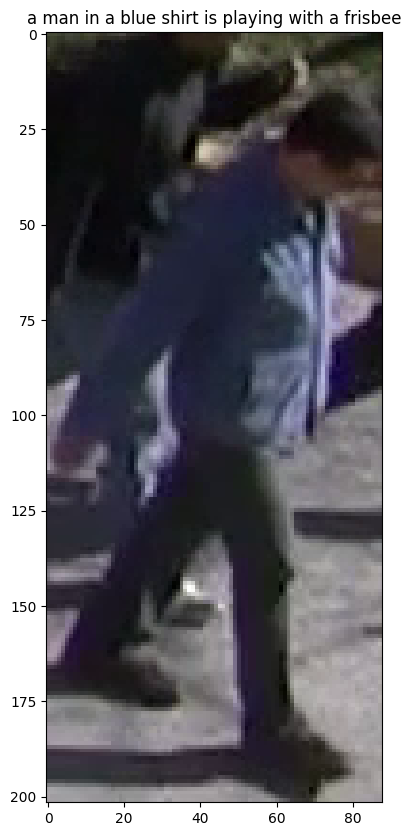

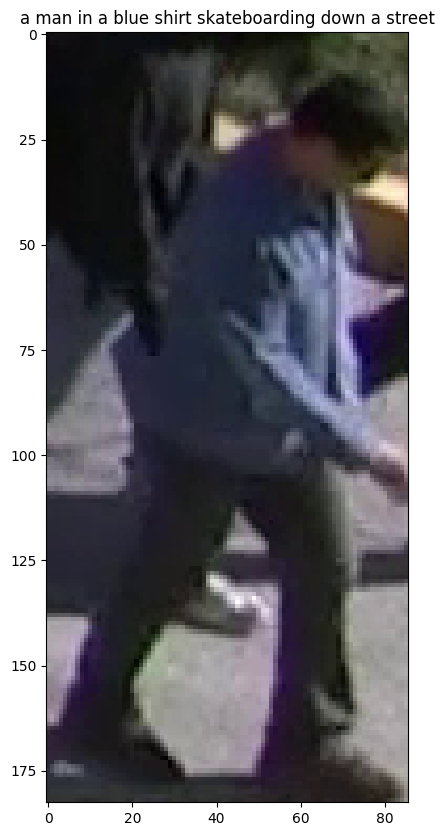

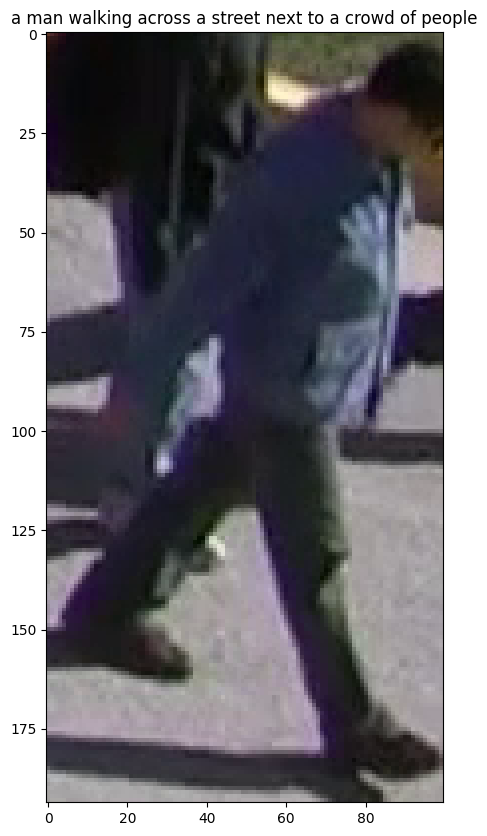

In [106]:
from decord import VideoReader
from decord import cpu, gpu


for x in range(len(unique_tracks)):
    track_id = unique_tracks[x]
    frame_id = frame_ids[x]
    x1, y1, x2, y2 = coords[x]
    
    vr = VideoReader(SOURCE_VIDEO_PATH, ctx=cpu(0))
    this_frame = vr.get_batch([frame_id])[0].numpy()
    this_frame_crop = this_frame[y1:y2, x1:x2]

    image = vis_processors["eval"](Image.fromarray(this_frame_crop)).unsqueeze(0).to(device)
    caption = model_blip.generate({"image": image})[0]

    plt.figure(figsize=(10,10))
    plt.title(caption)
    plt.imshow(this_frame_crop)
    plt.savefig(f"{OUTPUT_PATH}{track_id}.png")
